# Tutorial: Using the Epidexus Simulation
There is two phases in running a simulation with Epidexus. First you must create a synthetic world, next you run the actual simulation.
## The Model
Initially, we create a simulation model. This will hold references to all the agents (Persons and Locations) so that it can actuate them in the simulation phase. The agents also hold a reference to the model, so that they can access its global model parameters such as current (simulated) date. The model is initialized with the starting date (and time if necessarry) and the resolution of the simulation, we will choose one hour here. Also we are seeding the random engine to see the same results.

In [1]:
from epidexus import EpidexusModel
from datetime import datetime, timedelta
import numpy.random

sim_model = EpidexusModel(datetime(2020, 3, 31), sim_time_step=timedelta(hours=1))
numpy.random.seed(0)

## Building the world
There are two fundamental building blocks for creating a synthetic world. Locations and Persons. Each person has a home location and may go to other locations acording to an itinerary. You need to create a home location before you create a person, because you need to specify their home location when creating a person. Each location has an `infection_probability`, which is the probability that a susceptible person is infected by an infectious person in that same location within a time step (given in the model's `sim_time_step`). The reason that the probaility is tied to the location is that locations often dictate how close people are to each other but also which social interactions they have.


In [2]:
from epidexus import Location, Person, Gender
my_location = Location(sim_model, "Home", infection_rate=2.5)
my_person = Person(sim_model, my_location, age=25, gender=Gender.MALE)

These are two raw agents, which have not been registered with the simulation model yet. We need to do that in order for the model to actuate them.

In [3]:
sim_model.add_location(my_location)
sim_model.add_person(my_person)

### Convenience Functions for Family Creation
We can use some functions to make it easier to build our world. The simple `create_family` function creates a home location with a number of people living there. No gender or age of the persons are given, this is fine for simple simulations. Note that the function automatically adds the agents to the simulation model. Another experimental function `create_family_prob` is also available, this assigns a random number of parents and childern acording to a given distribution with random ages also sampled from distributions. For this tutorial, however, we will stick to the simple function.

In [4]:
from epidexus.world_creation import create_family
family, family_home = create_family(sim_model, 4)

If ages and genders are important, they can be changed after creation.

In [5]:
family[0].gender = Gender.MALE
family[0].age = 40
family[1].gender = Gender.FEMALE
family[1].age = 38
family[2].gender = Gender.MALE
family[2].age = 10
family[3].gender = Gender.FEMALE
family[3].age = 8

### Other Locations
If the people are not to just sit at home, we need to create some locations for them to go to. We will create a school and a workplace.

In [6]:
school = Location(sim_model, "Springfield Elementary", infection_rate=1.4)
work = Location(sim_model, "Harz Energiewerk Süd GmbH", infection_rate=0.5)
sim_model.add_locations([school, work])

The people need to know when to got to school or work, so whenever we make a new location, which is not a home location, we need to update the itineraries of the people associated with the locations. This is done by creating an itinerary entry and adding it to the person's itineraries. The `FixedWeekItineraryEntry` is perfect for places like schools and workplaces. It lets us define a weekly schedule that the persons should follow.

In [7]:
from epidexus.itinerary_entries import FixedWeekItineraryEntry
from datetime import time
school_it = FixedWeekItineraryEntry(school, sim_model.current_date.date(),
                                    monday=(time(8),time(14)),
                                    tuesday=(time(8),time(14)),
                                    wednesday=(time(8),time(14)),
                                    thursday=(time(8),time(14)),
                                    friday=(time(8),time(14)))
work_it = FixedWeekItineraryEntry(work, sim_model.current_date.date(),
                                  monday=(time(8),time(16)),
                                  tuesday=(time(8),time(16)),
                                  wednesday=(time(8),time(16)),
                                  thursday=(time(8),time(16)),
                                  friday=(time(8),time(16)))
my_person.itinerary.add_entry(work_it)
family[0].itinerary.add_entry(work_it)
family[1].itinerary.add_entry(work_it)
family[2].itinerary.add_entry(school_it)
family[3].itinerary.add_entry(school_it)

#### Claiming People
Above we assigned the itinerary entries by hand. But there is a convenience function to claim people by age. Let us make a couple of families and easily assign them to the work and school. We will add some random ages for fun. All the new people are put into the `new_people` list.

In [8]:
from numpy.random import uniform
from epidexus.world_creation import claim_by_age

new_people = []
for i in range(20):
    people, homes = create_family(sim_model, 4)
    people[0].gender = Gender.MALE
    people[0].age = uniform(30,50)
    people[1].gender = Gender.FEMALE
    people[1].age = uniform(30,50)
    people[2].gender = Gender.MALE
    people[2].age = uniform(6,16)
    people[3].gender = Gender.FEMALE
    people[3].age = uniform(6,16)
    new_people += people

new_people = claim_by_age(new_people, work_it, min_age=18, max_age=65, max_num=45)
new_people = claim_by_age(new_people, school_it, min_age=6, max_age=16, max_num=45)

The `claim_by_age` returns a new list with the claimed persons removes. Here, we just update the old list with the new one.

#### Spurious events
Not all locations need to be visited with a weekly schedule. Imagine that we want to model a super-infection event. For that, we will create a location that all will go to once. To address all persons, we will use the list of persons in the simulation model.

In [9]:
from epidexus import ItineraryEntry
show = Location(sim_model, "Danish Warmblood Stallion Show", infection_rate=10.0)
sim_model.add_location(show) #later, comment out this line
show_it = ItineraryEntry(show, go_when=datetime(2020, 4, 30, hour=16),
                               leave_when=datetime(2020, 4, 30, hour=22))
for p in sim_model.persons:
    p.itinerary.add_entry(show_it)

## Simulating
Now that we have built a small world, the next step is to simulate it. But in order for anything interesting to happen, we need to infect one of the persons. Then we will step through the simulation. We will simulate 120 days. Finally we will plot the SEIR-stackplot.

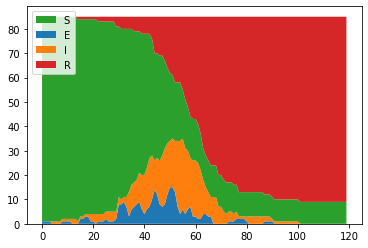

In [10]:
my_person.infect()

for i in range(120*24):
    sim_model.step()

from epidexus.plotting import seir_stackplot
seir_stackplot(sim_model)

As you can see our super-infection event at day 30 made quite a little difference (*The infection rate was also exeptionally high*). Try commenting out the line:
```
sim_model.add_location(show)
```
And you should see a delay in the peak of the infection curve.